In [45]:
# Import Libraries required for the course work 1
import numpy as np
import torch
import torchvision
from torch import nn, optim
from torchvision import  datasets
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import pandas as pd
import os
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
from config import *
from imagenet10 import ImageNet10
import csv
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [46]:
# Determine device type for using GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Read training & validation dataset

In [47]:
# Get Train & Validation Images from respective folders

paths, classes = [], []
for i, dir_ in enumerate(CLASS_LABELS):
    for entry in os.scandir(ROOT_DIR + dir_):
        if (entry.is_file()):
            #print(entry.path)
            paths.append(entry.path)
            classes.append(i)
            
data = {
    'path': paths,
    'class': classes
}

data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True) # Shuffles the data

# See what the dataframe now contains
print("Found", len(data_df), "images.")
# If you want to see the image meta data
print(data_df.head())

# Split the data into train and test sets and instantiate our new ImageNet10 objects.
train_split = 0.80 # Defines the ratio of train/valid data.

# valid_size = 1.0 - train_size
train_size = int(len(data_df)*train_split)

data_transform = transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD),
    ])

data_transform = transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Normalize(NORM_MEAN, NORM_STD),
    ])

dataset_train = ImageNet10(
    df=data_df[:train_size],
    transform=data_transform,
)

dataset_valid = ImageNet10(
    df=data_df[train_size:].reset_index(drop=True),
    transform=data_transform,
)

# Data loaders for use during training
train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=48,
    shuffle=True,
    num_workers=2
)

valid_loader = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=128,
    shuffle=True,
    num_workers=2
)

# Print the loaded data length
print("len(dataset_train)", len(dataset_train))
print("len(dataset_valid)", len(dataset_valid))

print("len(train_loader)", len(train_loader))
print("len(valid_loader)", len(valid_loader))

Found 9001 images.
                                                path  class
0       imagenet10/train_set/cat\n02123159_6516.JPEG      3
1  imagenet10/train_set/football\n04254680_8914.JPEG      7
2       imagenet10/train_set/cat\n02123159_6051.JPEG      3
3  imagenet10/train_set/football\n04254680_4369.JPEG      7
4    imagenet10/train_set/banana\n07753592_8490.JPEG      1
len(dataset_train) 7200
len(dataset_valid) 1801
len(train_loader) 150
len(valid_loader) 15


### GET SINGLE BATCH 

In [51]:
ite = iter(train_loader)
single_batch=next(ite)
(single_batch_input_images, single_batch_actual_labels) = single_batch
# print("image torch size--",single_batch_input_images.shape)
# print(single_batch_actual_labels)
single_batch_input_images = single_batch_input_images.to(device)
single_batch_actual_labels = single_batch_actual_labels.to(device)

image torch size-- torch.Size([48, 3, 128, 128])
tensor([8, 2, 8, 4, 1, 6, 1, 8, 6, 9, 5, 1, 3, 8, 8, 6, 9, 4, 6, 5, 0, 2, 8, 3,
        5, 5, 2, 9, 1, 3, 5, 9, 6, 7, 0, 3, 2, 5, 2, 9, 3, 7, 3, 0, 8, 8, 5, 5])


### EVALUATE LOADER

In [48]:
# Evaluates the data in the loader 
def evaluate_loader(loader, net):
    correct = 0
    total = 0
    running_loss = 0
    n = 0
    all_pred =torch.empty(0, dtype=int)
    all_actual = torch.empty(0, dtype=int)
    all_pred = all_pred.to(device)
    all_actual = all_actual.to(device)
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = loss_fn(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            all_pred=torch.cat((all_pred,predicted) ,dim=0)
            all_actual =torch.cat((all_actual,labels) ,dim=0)
            
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels
            running_loss += loss
            n += 1
    return running_loss/n, 100.0*correct/total ,all_pred,all_actual

### PREDICT TRAIN - SINGLE BATCH

In [49]:
# The below function evaluates a single batch of data that is passed as input to the function
def evaluate_train_single_batch(images,labels, net):
    correct = 0
    total = 0
    running_loss = 0
    with torch.no_grad():
        outputs = net(images)
        loss = loss_fn(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)    # add in the number of labels in this minibatch
        correct += (predicted == labels).sum().item()  # add in the number of correct labels
        running_loss += loss
    return running_loss, 100.0*correct/total 

### -----------------------------------------------------------------------------------------------

### 1 TRIAN SINGLE BATCH WITH LINEAR NETWORK & NO OPTIMIZATION

In [54]:
# the below block of code uses a Linear network to train a single batch of traing data 
BATCH_SIZE = 48
learning_rate = 0.001
num_epochs = 20
statsrec = np.zeros((5,num_epochs))
loss=0.0

# Define linear network without hidden layers
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(128*128*3, 10)
)
net = net.to(device)    

loss_fn = nn.CrossEntropyLoss()
optimizer_adm = torch.optim.Adam(net.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    net.train() 
    train_running_loss = 0.0
    train_acc = 0
    acc_test=0
    
    loss_test=0.0
    
    optimizer_adm.zero_grad()
    mdl_predictions_label = net(single_batch_input_images)
    loss = loss_fn(mdl_predictions_label, single_batch_actual_labels)
    loss.backward()
    optimizer_adm.step()

    train_running_loss += loss.detach().item()

    net.eval() 
    loss_test, acc_test = evaluate_train_single_batch(single_batch_input_images,single_batch_actual_labels, net)
    loss_val, acc_val, pred,actual = evaluate_loader(valid_loader, net)
    statsrec[:,epoch] = (train_running_loss, loss_test,loss_val, acc_test,acc_val)
    print('Epoch: %d |  T_Loss: %.4f | T_Acc: %.4f | V_Loss: %.4f | V_Acc: %.4f' %(epoch,loss_test,acc_test, loss_val , acc_val))   

Epoch: 0 |  T_Loss: 5.6938 | T_Acc: 58.3333 | V_Loss: 17.7106 | V_Acc: 13.4370
Epoch: 1 |  T_Loss: 6.7061 | T_Acc: 60.4167 | V_Loss: 26.0697 | V_Acc: 12.7707
Epoch: 2 |  T_Loss: 6.9210 | T_Acc: 56.2500 | V_Loss: 29.1516 | V_Acc: 11.3270
Epoch: 3 |  T_Loss: 4.9067 | T_Acc: 75.0000 | V_Loss: 27.2870 | V_Acc: 14.4364
Epoch: 4 |  T_Loss: 2.5953 | T_Acc: 81.2500 | V_Loss: 27.3763 | V_Acc: 13.9922
Epoch: 5 |  T_Loss: 0.9898 | T_Acc: 79.1667 | V_Loss: 26.7786 | V_Acc: 14.4364
Epoch: 6 |  T_Loss: 0.4384 | T_Acc: 93.7500 | V_Loss: 26.2352 | V_Acc: 14.6585
Epoch: 7 |  T_Loss: 0.6143 | T_Acc: 91.6667 | V_Loss: 27.0926 | V_Acc: 18.2121
Epoch: 8 |  T_Loss: 0.5082 | T_Acc: 91.6667 | V_Loss: 30.2478 | V_Acc: 16.7129
Epoch: 9 |  T_Loss: 0.3679 | T_Acc: 95.8333 | V_Loss: 29.1162 | V_Acc: 18.0455
Epoch: 10 |  T_Loss: 0.1218 | T_Acc: 97.9167 | V_Loss: 30.2444 | V_Acc: 17.0461
Epoch: 11 |  T_Loss: 0.0477 | T_Acc: 95.8333 | V_Loss: 31.5701 | V_Acc: 17.0461
Epoch: 12 |  T_Loss: 0.0636 | T_Acc: 97.9167 | V_L

### Graph 1.1.1  ---- LINEAR MODEL WITHOUT OPTIMIZATION

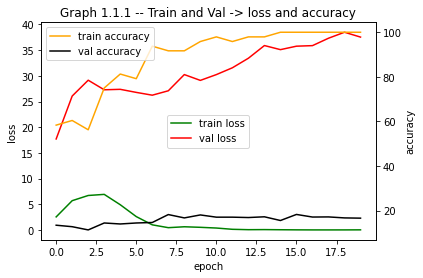

In [57]:
fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'g', label = 'train loss', )
#plt.plot(statsrec[1], 'g', label = 'test loss' )
plt.plot(statsrec[2], 'r', label = 'val loss' )
plt.legend(loc='center')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Graph 1.1.1 -- Train and Val -> loss and accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[3], 'orange', label = 'train accuracy')
ax2.plot(statsrec[4], 'black', label = 'val accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper left')
plt.show()

### ------------------------------------------------------------------------------------------------------------

### 2 MODEL WITH MULTI LAYERS - WITHOUT OPTIMIZATION

In [8]:
# A network with multiple layers but does not include any optimization
def initModelConv(): 
    net = nn.Sequential(
        nn.Conv2d(3,32, kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4, stride=2),
        
        nn.Conv2d(32,40, kernel_size=2, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(40,56, kernel_size=3,stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        
        nn.Flatten(),
        nn.Linear(7*7*56,1024),
        nn.ReLU(),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512,10)
    )

    for param in net.parameters():
        print(param.shape)
    
    return net

In [9]:
# Below block of code trains a multi layered neural network with a single batch of train data

BATCH_SIZE = 48
learning_rate = 0.001
num_epochs = 30
statsrec = np.zeros((5,num_epochs))
loss=0.0

net=initModelConv()
net = net.to(device)    

# for n, p in net.named_parameters():
#     print(p.device, '', n)
    
# for param in net.parameters():
#     print(param.shape)

loss_fn = nn.CrossEntropyLoss()
optimizer_adm = torch.optim.Adam(net.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    net.train() 
    train_running_loss = 0.0
    train_acc = 0
    acc_test=0
    
    loss_test=0.0
    
    optimizer_adm.zero_grad()
    mdl_predictions_label = net(single_batch_input_images)
    loss = loss_fn(mdl_predictions_label, single_batch_actual_labels)
    loss.backward()
    optimizer_adm.step()

    train_running_loss += loss.detach().item()

    net.eval() 
    loss_test, acc_test = evaluate_train_single_batch(single_batch_input_images,single_batch_actual_labels, net)
    loss_val, acc_val, pred,actual = evaluate_loader(valid_loader, net)
    statsrec[:,epoch] = (train_running_loss, loss_test,loss_val, acc_test,acc_val)
    print('Epoch: %d |  T_Loss: %.4f | T_Acc: %.4f | V_Loss: %.4f | V_Acc: %.4f' %(epoch,loss_test,acc_test, loss_val , acc_val))   

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([40, 32, 2, 2])
torch.Size([40])
torch.Size([56, 40, 3, 3])
torch.Size([56])
torch.Size([1024, 2744])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])
cuda:0  0.weight
cuda:0  0.bias
cuda:0  3.weight
cuda:0  3.bias
cuda:0  6.weight
cuda:0  6.bias
cuda:0  10.weight
cuda:0  10.bias
cuda:0  12.weight
cuda:0  12.bias
cuda:0  14.weight
cuda:0  14.bias
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([40, 32, 2, 2])
torch.Size([40])
torch.Size([56, 40, 3, 3])
torch.Size([56])
torch.Size([1024, 2744])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])
Epoch: 0 |  T_Loss: 2.2291 | T_Acc: 18.7500 | V_Loss: 2.3138 | V_Acc: 9.9944
Epoch: 1 |  T_Loss: 2.2461 | T_Acc: 18.7500 | V_Loss: 2.5484 | V_Acc: 9.9944
Epoch: 2 |  T_Loss: 2.1735 | T_Acc: 39.5833 | V_Loss: 2.3209 | V_Acc: 15.2693
Epoch: 3 |  T_Loss: 2.1331 | T_Acc: 56.2500 | V_Loss: 2.27

### Graph 1.1.2 ---- LINEAR MODEL WITH HIDDEN LAYERS & WITHOUT OPTIMIZATION

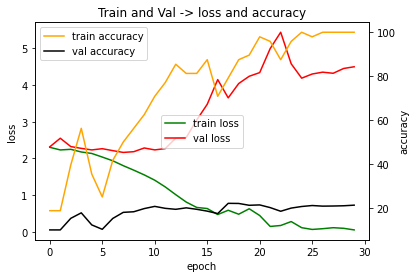

In [10]:
fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'g', label = 'train loss', )
plt.plot(statsrec[2], 'r', label = 'val loss' )
plt.legend(loc='center')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train and Val -> loss and accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[3], 'orange', label = 'train accuracy')
ax2.plot(statsrec[4], 'black', label = 'val accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper left')
plt.show()

### -----------------------------------------------------------------------------------------------------

### 3 TRAIN OPTIMIZED MODEL ON FULL TRAIN DATA

In [36]:
# A network with multiple layers and includes optimization ie Dropout & Batch normalization
def initModelConvOpt1(): 
    net_opt = nn.Sequential(
        nn.Conv2d(3,32, kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4, stride=2),
        
        nn.Conv2d(32,40, kernel_size=2, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.05),
        
        nn.Conv2d(40,56, kernel_size=3,stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Dropout(0.1),
        
        nn.Flatten(),
        nn.Linear(7*7*56,1024),
        nn.BatchNorm1d(num_features=1024),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(1024,512),
       
        nn.ReLU(),
        nn.Linear(512,10)
    )

    for param in net_opt.parameters():
        print(param.shape)
    
    return net_opt

In [9]:
#Below block of code trians optimized multi layer neural net with whole of training dataset
BATCH_SIZE = 48
learning_rate = 0.001
num_epochs =35
statsrec = np.zeros((5,num_epochs))
loss=0.0

netopt_fulltrain = initModelConvOpt1()
netopt_fulltrain = netopt_fulltrain.to(device)    

loss_fn = nn.CrossEntropyLoss()
optimizer_adm = torch.optim.Adam(netopt_fulltrain.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    netopt_fulltrain.train() 
    train_running_loss = 0.0
    train_acc = 0
    acc_test=0   
    loss_test=0.0

    for i, data in enumerate(train_loader, 0):
        netopt_fulltrain.train() 
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer_adm.zero_grad()
        mdl_predictions_label = netopt_fulltrain(inputs)
        loss = loss_fn(mdl_predictions_label, labels)
        loss.backward()
        optimizer_adm.step()

        train_running_loss += loss.detach().item()

    netopt_fulltrain.eval() 
    loss_train, acc_train,pred_train,actual_train = evaluate_loader(train_loader, netopt_fulltrain)
    loss_val, acc_val,pred_val,actual_val = evaluate_loader(valid_loader, netopt_fulltrain)
    statsrec[:,epoch] = (train_running_loss, loss_train,loss_val, acc_train,acc_val)
    print('Epoch: %d |  T_Loss: %.4f | T_Acc: %.4f | V_Loss: %.4f | V_Acc: %.4f' %(epoch,loss_train,acc_train, loss_val , acc_val))  
    
torch.save(netopt_fulltrain.state_dict(),"1.1_Full_train_28Feb-Model_Weights_35_epoc_opt2.model")

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([40, 32, 2, 2])
torch.Size([40])
torch.Size([56, 40, 3, 3])
torch.Size([56])
torch.Size([1024, 2744])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])
Epoch: 0 |  T_Loss: 1.6810 | T_Acc: 40.2639 | V_Loss: 1.6366 | V_Acc: 41.4214
Epoch: 1 |  T_Loss: 1.5107 | T_Acc: 47.7361 | V_Loss: 1.5124 | V_Acc: 45.1971
Epoch: 2 |  T_Loss: 1.3809 | T_Acc: 51.2639 | V_Loss: 1.4676 | V_Acc: 49.5836
Epoch: 3 |  T_Loss: 1.2580 | T_Acc: 56.5139 | V_Loss: 1.3040 | V_Acc: 53.2482
Epoch: 4 |  T_Loss: 1.2855 | T_Acc: 55.4306 | V_Loss: 1.4134 | V_Acc: 52.3043
Epoch: 5 |  T_Loss: 1.1128 | T_Acc: 61.0000 | V_Loss: 1.2154 | V_Acc: 57.3570
Epoch: 6 |  T_Loss: 1.1178 | T_Acc: 61.6528 | V_Loss: 1.1921 | V_Acc: 59.1338
Epoch: 7 |  T_Loss: 1.0203 | T_Acc: 64.7778 | V_Loss: 1.1353 | V_Acc: 60.3554
Epoch: 8 |  T_Loss: 0.9964 | T_Acc: 65.9861 | V_Loss: 1.1632 | V_Acc: 60.5775
Epoc

In [29]:
torch.save(netopt_fulltrain.state_dict(),"1.1_Full_train_28Feb-Model_Weights_35_epoc_transformed.model")

### Graph 1.2.1 ---- FINAL MODEL AFTER FINE TUNING & OPTIMIZATION

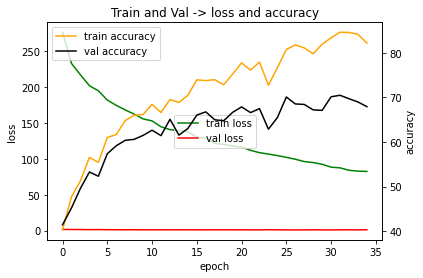

In [10]:
fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'g', label = 'train loss', )
#plt.plot(statsrec[1], 'g', label = 'test loss' )
plt.plot(statsrec[2], 'r', label = 'val loss' )
plt.legend(loc='center')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train and Val -> loss and accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[3], 'orange', label = 'train accuracy')
ax2.plot(statsrec[4], 'black', label = 'val accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper left')
plt.show()

### ---------------------------------------------------------------------------

### EVALUATE FULLY TRAINED MODEL ON FULL TRAINING SET

In [53]:
#load saved model
netopt_fulltrain=initModelConvOpt1()  

netopt_fulltrain.load_state_dict(torch.load("C:\\Users\\shilp\\Desktop\\AIHW\\1.1_Full_train_27Feb-Model_Weights_35_epoc_opt1.model", map_location=device))
netopt_fulltrain.eval()
loss_fn = nn.CrossEntropyLoss()


torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([40, 32, 2, 2])
torch.Size([40])
torch.Size([56, 40, 3, 3])
torch.Size([56])
torch.Size([1024, 2744])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])


In [12]:
# Do prediction on train set and validation set. The response is used to plot the confusion matrix
loss_fulltrain, acc_fulltrain, all_pred_train,all_actual_train = evaluate_loader(train_loader, netopt_fulltrain)
loss_val, acc_val,all_pred_val,all_actual_val = evaluate_loader(valid_loader, netopt_fulltrain)
print('T_Loss: %.4f | T_Acc: %.4f | V_Loss: %.4f | V_Acc: %.4f' %(loss_fulltrain,acc_fulltrain, loss_val , acc_val)) 

T_Loss: 0.5031 | T_Acc: 82.6111 | V_Loss: 1.0261 | V_Acc: 68.1843


### CONFUSION MATRIX of Train & Test evaluation

In [13]:
# Original class labels
original_labels = [
  "baboon",
  "banana",
  "canoe",
  "cat",
  "desk",
  "drill",
  "dumbbell",
  "football",
  "mug",
  "orange",
]

# CONFUSION MATRIX on TRAIN SET
def plot_confusion_matrix_train_data(predicted_label,actual_label):
    matrix = confusion_matrix(actual_label.view(-1).detach().cpu().numpy(), predicted_label.view(-1).detach().cpu().numpy())
    #print(arr)
    df_cm = pd.DataFrame(matrix, original_labels, original_labels)
    plt.figure(figsize = (10,10))
    plt.title("Confusion Matrix for Train Data", fontsize =20)
    sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.show()
    
    
# CONFUSION MATRIX on VALIDATION SET
def plot_confusion_matrix_validation_data(predicted_label,actual_label):
    matrix = confusion_matrix(actual_label.view(-1).detach().cpu().numpy(), predicted_label.view(-1).detach().cpu().numpy())
    #print(arr)
    df_cm = pd.DataFrame(matrix, original_labels, original_labels)
    plt.figure(figsize = (10,10))
    plt.title("Confusion Matrix for Validation Data", fontsize =20)
    sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.show()

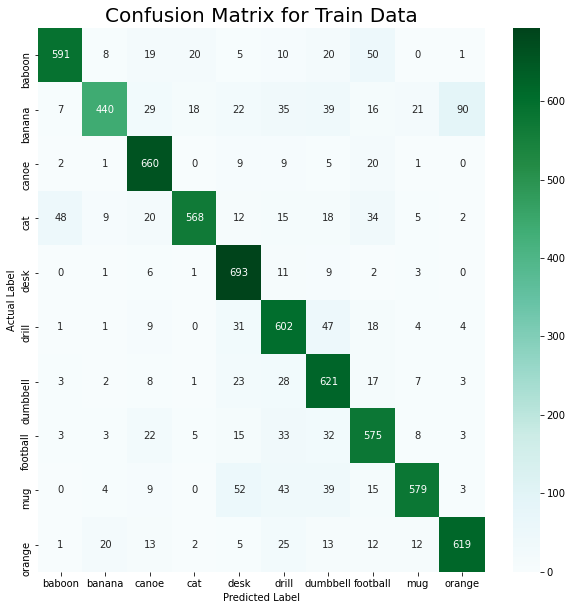

In [19]:
# Plot Confusion matrix for Train dataset evaluation
plot_confusion_matrix_train_data(all_pred_train,all_actual_train)

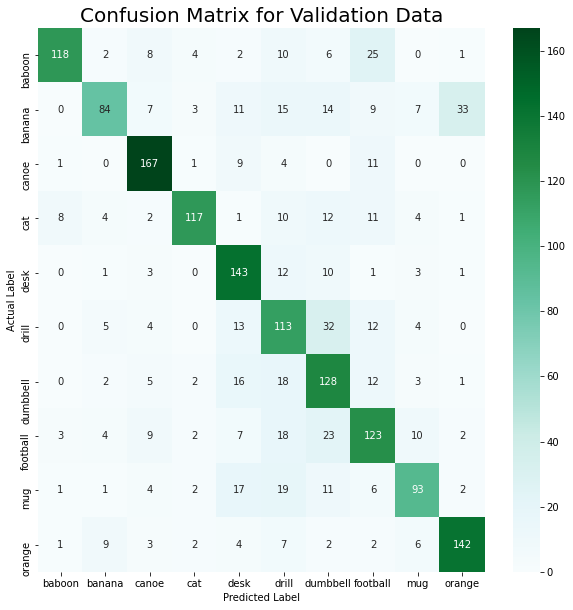

In [20]:
# Plot Confusion matrix for Validation dataset evaluation
plot_confusion_matrix_validation_data(all_pred_val,all_actual_val)

### ---------------------------------------------------------------------------------------

### PREDICTIN ON TEST SET

In [35]:
#Read images in TEST set folder
from imagenet11 import ImageNet10_TestLoader
paths_test = []
ROOT_TEST_DIR = "imagenet10/test_set/"
for entry in os.scandir(ROOT_TEST_DIR):
    if (entry.is_file()):
         paths_test.append(entry.path)
            
data_test = {
    'path': paths_test
}

test_data_transform = transforms.Compose([
        transforms.Resize(128),
         transforms.CenterCrop(128),
        transforms.ToTensor(),
             transforms.Normalize(NORM_MEAN, NORM_STD),
    ])

data_df_test = pd.DataFrame(data_test, columns=['path'])

print("Found", len(data_df_test), "images.")
print(data_df_test.head())

dataset_test = ImageNet10_TestLoader(
    df=data_df_test,
    transform=test_data_transform,
)

test_loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=50,
    shuffle=False,
    num_workers=2
)

Found 1000 images.
                                  path
0  imagenet10/test_set/abamijvuqu.JPEG
1  imagenet10/test_set/acqwaetjwm.JPEG
2  imagenet10/test_set/acuojomtzj.JPEG
3  imagenet10/test_set/adgnmsyawo.JPEG
4  imagenet10/test_set/aecbkuhafg.JPEG


In [41]:
# Predict function for test set
def evaluate_testset(loader, net):
    df_final=pd.DataFrame()
    with torch.no_grad():
        for data in loader:
            #print(type(data))
            images,path = data
            path_list = [ x.split("/")[2] for x in path  ]
            #images = images.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            d = {"image_name": path_list, "predicted_class_id": predicted.tolist()}
            #images = images.to(device)
            df = pd.DataFrame(data=d)
            df_final = df_final.append(df, ignore_index = True)
            #print("predicted: ",predicted)
        #print(df_final.shape[0])
        generate_prediction_csv(df_final)
    return "Done"

In [39]:
# Write Test set predictions to CSV file
def generate_prediction_csv(df_final):
    csv_file = "mm20skg_test_preds.csv"
    try:
        with open(csv_file, 'w',newline='') as csvfile:
            df_final.to_csv (csvfile, index = False, header=True)
    except IOError:
        print("I/O error")

In [42]:
#load model
device = "cpu"
nettrained=initModelConvOpt1()  

nettrained.load_state_dict(torch.load("C:\\Users\\shilp\\Desktop\\AIHW\\1.1_Full_train_28Feb-Model_Weights_35_epoc_transformed.model", map_location=device))
nettrained.eval()
loss_fn = nn.CrossEntropyLoss()

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([40, 32, 2, 2])
torch.Size([40])
torch.Size([56, 40, 3, 3])
torch.Size([56])
torch.Size([1024, 2744])
torch.Size([1024])
torch.Size([1024])
torch.Size([1024])
torch.Size([512, 1024])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])


In [44]:
# Invoke predict function
res = evaluate_testset(test_loader, nettrained)
print(res)
#print('V_Loss: %.4f | V_Acc: %.4f' %(loss_test , acc_test)) 

Done
